# SENTIMENT ANALYSIS FOR STOCK MARKET PREDICTION

## 2. Readying the Data

### Tasks performed in this section:
1. Read the combined data file
2. Create a new DataFrame df_compute with just the prices from the original Dataframe.
3. Add columns compound, neg, pos, neu to the dataframe
4. For each day in the origina DataFrame calculate sentiment values and store it to corresponding day's record in df_compute
5. Split df_compute into training and testing data sets
6. y_train and y_test have the target values which are the prices and ndf_train and ndf_test have features. For features we use only pos and neg values as the importance of compound and neu values are negligible.

In [1]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from treeinterpreter import treeinterpreter as ti
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Sam\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
df_stocks = pd.read_csv('combinedDataFile.csv', index_col = 0)
df_compute = df_stocks[['prices']].copy()

# Adding new columns to the data frame
df_compute["compound"] = ''
df_compute["neg"] = ''
df_compute["neu"] = ''
df_compute["pos"] = ''

#Sentiment Analysis
sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    #try:
    sentence = unicodedata.normalize('NFKD', unicode(df_stocks.loc[date, 'articles'])).encode('ascii','ignore')
    ss = sid.polarity_scores(sentence)
    df_compute.at[date, 'compound']= ss['compound']
    df_compute.at[date, 'neg']= ss['neg']
    df_compute.at[date, 'neu']= ss['neu']
    df_compute.at[date, 'pos']=ss['pos']    #except TypeError:
    #    print df_stocks.loc[date, 'articles']
    #    print date

train_start_date = '2008-08-08'
train_end_date = '2015-07-17'
test_start_date = '2015-07-20'
test_end_date = '2016-07-01'

train = df_compute[(df_compute.index <= train_end_date)]
test = df_compute[(df_compute.index > train_end_date)]


sentiment_score_list = []
for index, row in train.T.iteritems():
    #sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
    sentiment_score = np.asarray([df_compute.loc[index, 'neg'],df_compute.loc[index, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_train = np.asarray(sentiment_score_list)
ndf_train = pd.DataFrame(numpy_df_train)
print ndf_train.head()

sentiment_score_list = []
for date, row in test.T.iteritems():
    #sentiment_score = np.asarray([df.loc[date, 'compound'],df.loc[date, 'neg'],df.loc[date, 'neu'],df.loc[date, 'pos']])
    sentiment_score = np.asarray([df_compute.loc[date, 'neg'],df_compute.loc[date, 'pos']])
    sentiment_score_list.append(sentiment_score)
numpy_df_test = np.asarray(sentiment_score_list)
ndf_test = pd.DataFrame(numpy_df_test)


y_train = pd.DataFrame(train['prices'])
y_test = pd.DataFrame(test['prices'])



       0      1
0  0.142  0.074
1  0.119  0.115
2  0.129  0.067
3  0.119  0.081
4  0.154  0.067


## 3. Implementing Random Forest and MLP  Classifier on our Data

### Random Forest Regressor
In this section, we implement the random forest regressor on our data. 
1. First, we fit our data into a random forest regressor.
2. We make a prediction using that model.
3. Since the predictions are far apart from actual prices, we align the prices by adding the average difference to the predicted price.
4. After aligning, we also use the EWMA to smoothen the prediction.
5. We then plot the graphs.

C:\Users\Sam\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


('Mean Absolute Error: $', 4093.94)
17225
13157.813388429753
4067.186611570247
('Mean Absolute Error: $', 629.5)


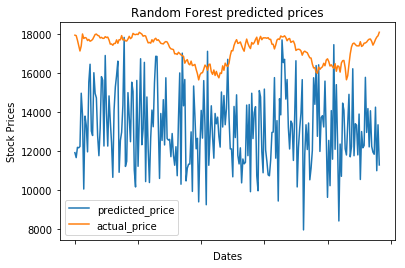

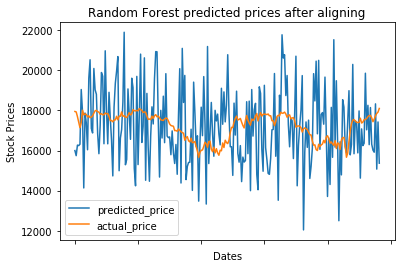

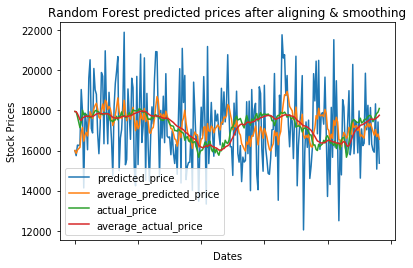

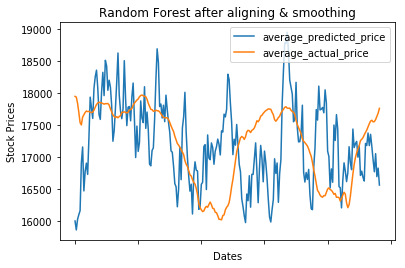

In [3]:
rf = RandomForestRegressor()

rf.fit(ndf_train, y_train)



prediction, bias, contributions = ti.predict(rf, numpy_df_test)

idx = test.index.values
predictions_df = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])

errors = abs(predictions_df - y_test)
print('Mean Absolute Error: $', round(np.mean(errors), 2))

ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Random Forest predicted prices')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
fig.savefig("random forest without smoothing.png")

count = 0
total_test = 0
for index, row in test.iterrows():
    total_test += test.loc[index, 'prices']
    count += 1
average_test = total_test/count
print average_test

count = 0
total_predicted = 0
for index, row in predictions_df.iterrows():
    total_predicted += predictions_df.loc[index, 'prices']
    count += 1
average_predicted = total_predicted/count
print average_predicted

difference = average_test - average_predicted
print difference

predictions_df['prices'] = predictions_df['prices'] + difference

ax = predictions_df.rename(columns={"prices": "predicted_price"}).plot(title='Random Forest predicted prices after aligning')
ax.set_xlabel("Dates")
ax.set_ylabel("Stock Prices")
fig = y_test.rename(columns={"prices": "actual_price"}).plot(ax = ax).get_figure()
fig.savefig("random forest with aligning.png")

predictions_df['ewma'] = predictions_df["prices"].ewm(span=10).mean()
predictions_df['actual_value'] = test['prices']
predictions_df['actual_value_ewma'] = predictions_df["actual_value"].ewm(span=10).mean()

predictions_df.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
# Now plotting test predictions after smoothing
predictions_plot = predictions_df.plot(title='Random Forest predicted prices after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()
fig.savefig("random forest after smoothing.png")

# Plotting just predict and actual average curves
predictions_df_average = predictions_df[['average_predicted_price', 'average_actual_price']]

errors1 = abs(predictions_df_average['average_predicted_price'] - predictions_df_average['average_actual_price'])
print('Mean Absolute Error: $', round(np.mean(errors1), 2))

predictions_plot = predictions_df_average.plot(title='Random Forest after aligning & smoothing')
predictions_plot.set_xlabel("Dates")
predictions_plot.set_ylabel("Stock Prices")
fig = predictions_plot.get_figure()
fig.savefig("random forest after smoothing 2.png")

### MLP Classifier
In this section, we implement the MLPClassifier on our data.

1. First, we fit our data into a MLP Classifier.
2. We make a prediction using that model.
3. Since the predictions are far apart from actual prices, we align the prices by adding the average difference to the predicted price.
4.  After aligning, we also use the EWMA to smoothen the prediction.
5. We then plot the graphs.

('Mean Absolute Error: $', 4096.6)
17225
13299
('Mean Absolute Error: $', 2522.95)


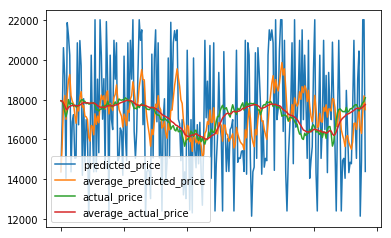

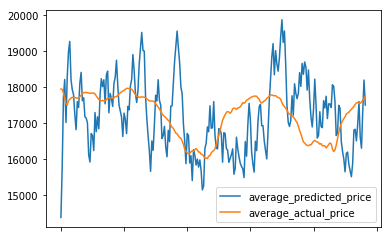

In [5]:

mlpc = MLPClassifier(hidden_layer_sizes=(100, 200, 100), activation='relu', solver='lbfgs', alpha=0.005, learning_rate_init = 0.001, shuffle=False) # span = 20 # best 1
mlpc.fit(numpy_df_train, train['prices'])   

prediction = mlpc.predict(numpy_df_test)



prediction_list =[]

prediction_list.append(prediction)

idx = test.index.values
#print year
predictions_df_list = pd.DataFrame(data=prediction[0:], index = idx, columns=['prices'])

predictions_df_list
errors = abs(predictions_df_list - y_test)
print('Mean Absolute Error: $', round(np.mean(errors), 2))

count = 0
total_test = 0
for index, row in test.iterrows():
    total_test += test.loc[index, 'prices']
    count += 1
average_test = total_test/count
print average_test

count = 0
total_predicted = 0
for index, row in predictions_df_list.iterrows():
    total_predicted += predictions_df_list.loc[index, 'prices']
    count += 1
average_predicted = total_predicted/count
print average_predicted

difference = average_test - average_predicted
    
# Adding offset to all the advpredictions_df price values
predictions_df_list['prices'] = predictions_df_list['prices'] + difference
errors = abs(predictions_df_list - y_test)
# Smoothing the plot
predictions_df_list['ewma'] = predictions_df_list["prices"].ewm(span=10).mean()
predictions_df_list['actual_value'] = test['prices']
predictions_df_list['actual_value_ewma'] =predictions_df_list["actual_value"].ewm(span=10).mean()


print('Mean Absolute Error: $', round(np.mean(errors), 2))

# Changing column names
predictions_df_list.columns = ['predicted_price', 'average_predicted_price', 'actual_price', 'average_actual_price']
predictions_df_list.plot()
predictions_df_list_average = predictions_df_list[['average_predicted_price', 'average_actual_price']]
predictions_df_list_average.plot()
   

## Evaluation

Comparing the Mean Absolute Errors of the two models, Random Forest seems to give the best results. But comparisons of MLP Classifer and Random Forest Regressors on the internet tell a different story. The results of these models are data dependent. And this might be one of the reasons for such a result.

## Conclusion

The takeaway from this project for me is the technique and process that can be undertaken to predict stock prices based on sentiment analysis of the market and historical data. If we can work on getting targetted news sections which have direct impact on stock and use a tool more specific for sentiment analysis of News headlines, we could have a different and a better result than what was achieved in this project.

## References

[1] https://www.investopedia.com/terms/a/adjusted_closing_price.asp
[2] http://datameetsmedia.com/vader-sentiment-analysis-explained/
[3] https://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html/2
[4] https://www.techleer.com/articles/107-random-forest-supervised-classification-machine-learning-algorithm/
[5] https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
[6]  https://monkeylearn.com/sentiment-analysis/
[7] https://github.com/Crystal21/Stock-prediction-using-Twitter-sentiment-analysis
[8] https://www.codeproject.com/Articles/1201444/Stock-Predictions-through-News-Sentiment-Analysis
[9] https://finance.yahoo.com/quote/%5EDJI?p=^DJI